In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
# Carga Fichero

import pandas as pd

datos = pd.read_csv('Modelar_UH2022.txt',sep='|',parse_dates=['SAMPLETIME'],infer_datetime_format=True)

In [ ]:
#Modelar_UH2022_10_Contadores.txt
datos[datos['ID']<11].to_csv('Modelar_UH2022_10_Contadores.txt',sep='|',index=False,float_format='%.0f')

In [21]:
datos[datos['ID']<3].to_csv('Modelar_UH2022_2_Contadores.txt',sep='|',index=False,float_format='%.0f')

In [32]:
datos[datos['ID']==2735].to_csv('Modelar_UH2022_Contador_2735.txt',sep='|',index=False,float_format='%.0f')

In [22]:
datos[datos['ID']==2561].to_csv('Modelar_UH2022_Contador_2561.txt',sep='|',index=False,float_format='%.0f')

In [2]:
datos[datos['ID']==2562].to_csv('Modelar_UH2022_Contador_2562.txt',sep='|',index=False,float_format='%.0f')

In [33]:
datos[datos['ID']==167].to_csv('Modelar_UH2022_Contador_167.txt',sep='|',index=False,float_format='%.0f')

In [34]:
datos[datos['ID']==2521].to_csv('Modelar_UH2022_Contador_2521.txt',sep='|',index=False,float_format='%.0f')

In [22]:
datos[datos['ID']==2748].to_csv('Modelar_UH2022_Contador_2748.txt',sep='|',index=False,float_format='%.0f')

numexpr.utils INFO  NumExpr defaulting to 6 threads.


# CLASE PARA PROYECTO CAJAMAR

In [1]:
!pip install skforecast

In [2]:
# Librerias

import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import timedelta
from datetime import date
from sklearn.metrics import mean_squared_error
#from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
#from skforecast.model_selection import grid_search_forecaster, backtesting_forecaster
import model_selection_no_print
#from typing import Union, Optional
from sklearn.preprocessing import StandardScaler
import math
from joblib import dump, load
import pickle


class Contador(object):
    def __init__(self, datos_contador, ID, umbral, Modelo_Semanal, Media_Movil, Fecha_Fin, Cargar_Modelo):
        self.datos_contador = datos_contador
        self.ID = ID
        self.umbral = umbral
        self.Modelo_Semanal = Modelo_Semanal
        self.Media_Movil = Media_Movil
        self.Fecha_Fin = Fecha_Fin
        self.Cargar_Modelo = Cargar_Modelo
        self.Preprocesado()
        self.SinDatos = False  # NO TIENE DATOS DATASET VACIO
        #self.outlier = False
        self.dias = 0
        self.RMSE_Train = 0
        self.RMSE_Test = 0
        self.datos_test = pd.DataFrame()
        self.datos_test_semanal = pd.DataFrame()
        self.Mejor_Parametro = {}
        self.Mejor_Lag = 14 
        self.DiffConsumo = 0
        self.LecturaErronea = False
        
        # {'ID','Dia_1':0,'Dia_2':0,'Dia_3':0,'Dia_4':0,'Dia_5':0,'Dia_6':0','Dia_7':0,'Semana_1':0,'Semana_2':0}
        self.Predicciones = [self.ID,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        
        if not datos_contador.empty:
            # CALCULO LECTURA CONTADOR Y CONSUMO JUNTANDO DECIMALES
            #
            
            self.datos_contador = self.datos_contador.set_index('SAMPLETIME')
            self.datos_contador['LECTURA'] = self.datos_contador['READINGINTEGER'] + (self.datos_contador['READINGTHOUSANDTH'] / 100)
            self.datos_contador['CONSUMO'] = self.datos_contador['DELTAINTEGER'] + (self.datos_contador['DELTATHOUSANDTH'] / 100)
            self.datos_contador['CONSUMO_CAL'] = self.datos_contador['LECTURA'].diff(1).fillna(0)   # CALCULO DEL CONSUMO CON LA LECTURA

            
            
            self.__Comprobar_Consumo()
            #if self.DiffConsumo > 100000:
            #    self.datos_contador['CONSUMO'] = self.datos_contador['CONSUMO_CAL']

            # CONSUMO POR DIAS
            # RESAMPLE
            
            self.datos_consumo = pd.DataFrame(self.datos_contador['CONSUMO'].resample(rule='1D', closed='left', label ='left').sum())
            #self.datos_consumo['CONSUMO_NORM'] = (self.datos_consumo['CONSUMO'] - self.datos_consumo['CONSUMO'].mean()) / self.datos_consumo['CONSUMO'].std()
            # MEDIAS MÓVILES
            if self.Media_Movil > 0:
                self.datos_consumo['CONSUMO_MED'] = self.datos_consumo['CONSUMO'].rolling(self.Media_Movil).mean()
                self.datos_consumo['CONSUMO_MED'].fillna(0,inplace=True)
            else:
                self.datos_consumo['CONSUMO_MED'] = self.datos_consumo['CONSUMO']
            
            self.datos_consumo_semanal = pd.DataFrame(self.__SemanaCompleta()['CONSUMO'].resample(rule='1W', closed='left', label ='left').sum())
            
            # COGER SOLO SEMANAS COMPLETAS
            #self.__SemanaCompleta()
            
            # ESTADISTICAS
            self.dias = len(self.datos_consumo.index)
            self.semanas = len(self.datos_consumo_semanal.index)
            #self.datos_consumo['Cuenta'] = self.datos_contador.groupby([self.datos_contador.index.year,self.datos_contador.index.month, self.datos_contador.index.day]).agg({'CONSUMO':'count'}).values
            
            self.fecha_inicio_contador= self.datos_consumo.index[0]
            self.fecha_fin_contador= self.datos_consumo.index[-1]
            
        else:
            self.datos_consumo = pd.DataFrame()
            self.SinDatos = True
            self.fecha_fin_contador = None

        # GENERACION DEL MODELO
        self.modelo()
    
    def __SemanaCompleta(self):
        # PARTIENDO DE LOS 7 DIAS INICIALES Y 7 DIAS FINALES DE datos_consumo
        # DEVUELVE datos_consumo ELIMINANDO LAS SEMANAS COMPLETAS

        index_inicio = 0
        index_fin = 0
        semana = 0

        # DATOS CONSUMO TAIL VER DIA SEMANA

        for fecha in self.datos_consumo.head(7).index:
            if semana == 0:
                semana = fecha.isocalendar()[1]
            elif semana != fecha.isocalendar()[1]:
                break
            index_inicio += 1
        semana = 0
        for fecha in self.datos_consumo.tail(7).index:
            if semana == 0:
                semana = fecha.isocalendar()[1]
            elif semana != fecha.isocalendar()[1]:
                index_fin = 7 - index_fin
                break
            index_fin += 1

        if index_fin == 0:
            return(self.datos_consumo[index_inicio:])
        else:
            return(self.datos_consumo[index_inicio:-index_fin])


    def __Comprobar_Consumo(self):
        # COMPRUEBA SI HAY MAS DE 1 LITRO DE DIFERENCIA ENTRE EL CONSUMO EL CALCULO DEL CONSUMO CON LA LECTURA DEL CONTADOR
        # EL VALOR ACUMULADO SE GUARDA EN DiffConsumo

        if not(self.datos_contador['CONSUMO_CAL'].equals(self.datos_contador['CONSUMO'])):
            for index, row in self.datos_contador.iterrows():
                if np.absolute(row['CONSUMO_CAL']) != row['CONSUMO'] and (np.absolute(row['CONSUMO_CAL'] - row['CONSUMO']) > 1):
                    #print(row['CONSUMO_CAL'] - row['CONSUMO'])
                    #print(index,row)
                    self.DiffConsumo += np.absolute(row['CONSUMO_CAL'] - row['CONSUMO'])
        
    def __Convertir_fecha(self, serie):
        fechas = []
        for año, mes, dia in serie.index:
            fechas.append(date(año,mes,dia))
        return fechas
    
    def Preprocesado(self):
        # SAMPLETIME READINGINTEGER	READINGTHOUSANDTH	DELTAINTEGER	DELTATHOUSANDTH
        # VALORES  NULOS 
        # VALORES ENTEROS INTERPOLAMOS
        

        self.datos_contador['READINGINTEGER'].interpolate(inplace=True)
        self.datos_contador['DELTAINTEGER'].interpolate(inplace=True)
        
        # VALORES DECIMALES SUSTITUIMOS POR CERO
        self.datos_contador['READINGTHOUSANDTH'].fillna(0,inplace=True)
        self.datos_contador['DELTATHOUSANDTH'].fillna(0,inplace=True)
        
        # ELIMINAR VALORES NEGATIVOS
        indices = self.datos_contador[self.datos_contador['READINGINTEGER'] < 0].index
        self.datos_contador.drop(indices,inplace=True)
        indices = self.datos_contador[self.datos_contador['DELTAINTEGER'] < 0].index
        self.datos_contador.drop(indices,inplace=True)

        # NORMALIZAR NO ES NECESARIO EN EL CASO DE RANDOM FOREST REGRESSOR

    def modelo(self):
        # DECISION DEL MODELO A TOMAR EN FUNCION DE LA ESTADISTICAS
        # CARGA DEL MODELO
        # PACO
        self.model = None
        if self.dias > self.umbral: 
            if self.fecha_fin_contador == self.Fecha_Fin:
                if self.Cargar_Modelo:  # CARGAR MODELO DESDE FICHERO
                    self.model = load('./modelos/Modelo_ID_' + str(self.ID))
                    if isinstance(contador.model,ForecasterAutoreg):
                        self.Mejor_Lag = self.model.max_lag
                        self.Mejor_Parametro = {'max_depth':self.model.regressor.max_depth,'n_estimators':self.model.regressor.n_estimators}
                else:   # USAR MODELO GENERICO
                    # RandomForestRegressor Diario
                    self.model = ForecasterAutoreg(regressor=RandomForestRegressor(random_state=123), lags=14)
                    # RandomForestRegressor Semanal
                    self.model_Semanal = ForecasterAutoreg(regressor=RandomForestRegressor(random_state=123), lags=2)
            else:
                self.model = self.datos_consumo['CONSUMO'].mean()
        else:
            if self.dias > 0: 
                #if (self.fecha_fin_contador > date(2020,1,17)).bool() :    # HACE MEDIA SI TENEMOS DATOS EN LOS ULTIMOS 14 DIAS
                self.model = self.datos_consumo['CONSUMO'].mean()
                #else:
                #self.model = 0
            else:
                self.model = 0

    def Juntar_Datos(self):
        # REHACE EL MODELO CON LOS MEJORES PARAMETROS
        # JUNTA TODO EN datos_consumo

        self.datos_consumo = pd.concat([self.datos_consumo,self.datos_test])
        self.datos_test =pd.DataFrame()
        
        
    

class CajaMar_Water(object):
    def __init__(self,Ruta_Datos,Ruta_Mejor='resultados_1_30.xlsx',Fecha_Inicio=date(2019,2,1),Fecha_Fin=date(2020,1,31),
                umbral_modelo=100, Modelo_Semanal=False, Media_Movil=0,Cargar_Modelos=False,Cargar_Conf_modelo=False):
        self.Ruta_Datos = Ruta_Datos
        self.Ruta_Mejor = Ruta_Mejor
        self.Fecha_Inicio = Fecha_Inicio
        self.Fecha_Fin = Fecha_Fin
        self.umbral_modelo = umbral_modelo
        self.Modelo_Semanal = Modelo_Semanal    # True usamos dos modelos uno para dias y otro para semanas
        self.Media_Movil = Media_Movil
        self.Cargar_Modelos = Cargar_Modelos
        self.Cargar_Conf_modelo = Cargar_Conf_modelo
        self.datos = pd.DataFrame()
        self.contadores = []
        self.dias_test = 14     # DIAS QUE SE RESERVAN PARA TEST EMPEZANDO POR LA FECHA MAS RECIENTE
        self.semanas_test = 2   # SEMANAS QUE SE RESERVAN PARA TEST
        self.Cargar_Datos()
        self.RMSE_Test_Promedio=0
        self.RMSE_Test_Suma=0
        self.dataframe_RMSE = pd.DataFrame()
        
    

    def Cargar_Datos(self):
        print('CARGANDO DATOS.....')
        self.datos = pd.read_csv(self.Ruta_Datos,sep='|',parse_dates=['SAMPLETIME'],infer_datetime_format=True,encoding='utf-8')
        self.datos.sort_values(by=['ID','SAMPLETIME'],inplace=True)
        self.Mejor_Preprocesado = pd.read_excel(self.Ruta_Mejor,index_col=0)
        
 
        # GENERANDO CONTADORES
        print('GENERANDO CONTADORES.....')
        for ID in tqdm(pd.unique(self.datos['ID'])):
            # ALMACENAMOS ID DE CONTADOR Y BORRAMOS LA COLUMNA
            # Resultados.iloc[0]['Mejor']
            self.contadores.append(Contador(self.datos[self.datos['ID']==ID].drop('ID',axis=1),ID,self.umbral_modelo,self.Modelo_Semanal,
                                            int(self.Mejor_Preprocesado.loc[ID]['Mejor']),self.Fecha_Fin,self.Cargar_Modelos))

        print('PROCESO DE CARGA FINALIZADO')
        if self.Cargar_Conf_modelo:
            print('ACTUALIZANDO CONFIGURACIÓN MODELOS')
            Res_load = pd.read_excel('Conf_modelos.xlsx',index_col=0)
            for contador in tqdm(self.contadores):
                try:
                    contador.Mejor_Parametro = {'max_depth':Res_load.loc[contador.ID]['max_depth'],
                                                'n_estimators':Res_load.loc[contador.ID]['n_estimators'],
                                                'lags':list(range(Res_load.loc[contador.ID]['Lag'] + 1))}
                    contador.model.set_params(**contador.Mejor_Parametro)
                    #contador.model.lags = list(range(Res_load.loc[contador.ID]['Lag'] + 1))
                    contador.Mejor_Lag = Res_load.loc[contador.ID]['Lag']
                    
                except:
                    None
    
    
    def PartirDatos(self):
        # Separar datos de entrenamiento y test / validacion (dias=0 no hace validacion)
        if self.dias_test > 0:     
            for contador in tqdm(self.contadores):
                if contador.SinDatos == False:      # COMPROBAMOS QUE HAY ALGUN REGISTRO
                    #if (contador.fecha_fin_contador==self.Fecha_Fin):
                    if contador.dias > self.dias_test + 1:    # COMPROBAMOS QUE HAY SUFICIENTES DATOS PARA HACER PARTICION
                        contador.datos_test = contador.datos_consumo.tail(self.dias_test)
                        contador.datos_consumo = contador.datos_consumo[0:-self.dias_test]
                    if contador.semanas > self.semanas_test + 1:
                        contador.datos_test_semanal = contador.datos_consumo_semanal.tail(self.semanas_test)
                        contador.datos_consumo_semanal = contador.datos_consumo_semanal[0:-self.semanas_test]


    
    def Grid_Search(self,ID,steps):
        # Hiperparámetros del regresor
        param_grid = {'n_estimators': [100,200],
              'max_depth': [3, 5, 10]}

        # Lags utilizados como predictores
        lags_grid = [14, 30]

        resultados_grid = model_selection_no_print.grid_search_forecaster(
                                forecaster         = self.contadores[ID].model,
                                y                  = self.contadores[ID].datos_consumo['CONSUMO'],
                                param_grid         = param_grid,
                                lags_grid          = lags_grid,
                                steps              = steps,
                                refit              = True,
                                metric             = 'mean_squared_error',
                                initial_train_size = len(self.contadores[ID].datos_consumo) - 14,
                                return_best        = True,
                                verbose            = False)
        self.contadores[ID].RMSE_Train = math.sqrt(resultados_grid['metric'].head(1))
        self.contadores[ID].Mejor_Parametro = list(resultados_grid['params'])[0]
        self.contadores[ID].Mejor_Lag = max(list(resultados_grid['lags'].head(1))[0])    

    def Entrenamiento(self,Grid=False):
        # Entrenamiento de los modelos en self.contadores(lista) 
        # iterar lista y llamar a self.contadores[iter].modelo.train
        # Rellena la variable self.contadores.Predicciones

        print('ENTRENANDO MODELOS.....')
        indexC = 0
        for contador in tqdm(self.contadores):
            if isinstance(contador.model,ForecasterAutoreg):    # COMPROBAMOS QUE ES UN MODELO
                if Grid:
                    self.Grid_Search(indexC,self.dias_test)
                    #contador.Juntar_Datos() #  JUNTA LOS DATOS PARA LUEGO HACER PREDICT
                
                #contador.model.fit(y=contador.datos_consumo['CONSUMO_NORM'])
                
                contador.model.fit(y=contador.datos_consumo['CONSUMO_MED'])

                predict = contador.model.predict(steps=self.dias_test)

                if self.Modelo_Semanal:
                    contador.model_Semanal.fit(y=contador.datos_consumo_semanal['CONSUMO'])
                    predict_semanal = contador.model_Semanal.predict(steps=self.semanas_test)
                # HAY QUE TENER EN CUENTA CUANDO TERMINAN LOS DATOS
                #predict = contador.model.predict(steps=self.dias_test) * contador.datos_consumo['CONSUMO'].std() + contador.datos_consumo['CONSUMO'].mean()
                
                index = 1
                for predict_dia in predict[0:14]:    # GUARDA 14 DIAS PREDICCION
                    contador.Predicciones[index] = predict_dia
                    index += 1
                if self.Modelo_Semanal:
                    contador.Predicciones[15]=predict_semanal[0]              # GUARDA SEMANA1 PREDICCION
                    contador.Predicciones[16]=predict_semanal[1]              # GUARDA SEMANA2 PREDICCION
                else:
                    contador.Predicciones[15]=predict[0:7].sum()     # GUARDA SEMANA1 PREDICCION
                    contador.Predicciones[16]=predict[7:14].sum()    # GUARDA SEMANA2 PREDICCION
            else:
              for index in range(1,15):
                    contador.Predicciones[index] = contador.model  # GUARDAMOS MEDIA EN LOS 7 DIAS
              contador.Predicciones[15]=contador.model*7     # GUARDAMOS MEDIA SEMANA1
              contador.Predicciones[16]=contador.model*7     # GUARDAMOS MEDIA SEMANA2
            
            indexC += 1
                  

    def Calculo_RMSE(self):
        # Calculo rmse utlizando datos de test
        print('CALCULANDO RMSE.....')
        RMSE_Todos = []
        ID_Todos = []
        for contador in tqdm(self.contadores):
            #if contador.dias > 180 and len(contador.datos_test) == self.dias_test:  # VER LIMITE NO DEPENDE DE LA CLASE CONTADOR
            if len(contador.datos_test) == self.dias_test and len(contador.datos_test_semanal) == self.semanas_test:
                if self.Modelo_Semanal:
                    media_RMSE_semanal=math.sqrt(mean_squared_error(contador.datos_test_semanal['CONSUMO'] , [contador.Predicciones[15], contador.Predicciones[16]]))
                else:
                    media_RMSE_semanal=math.sqrt(mean_squared_error([contador.datos_test['CONSUMO'][0:7].sum(), contador.datos_test['CONSUMO'][7:14].sum()] , [contador.Predicciones[15], contador.Predicciones[16]]))
                
                contador.RMSE_Test = 0.5*math.sqrt(mean_squared_error(contador.datos_test['CONSUMO'][0:7],contador.Predicciones[1:8]))+0.5*media_RMSE_semanal
                
                RMSE_Todos.append(contador.RMSE_Test)
                ID_Todos.append(contador.ID)

        self.RMSE_Test_Suma = sum(RMSE_Todos)
        if self.RMSE_Test_Suma != 0:
            self.RMSE_Test_Promedio = self.RMSE_Test_Suma / len(RMSE_Todos)
            self.dataframe_RMSE = pd.DataFrame(data=RMSE_Todos,index=ID_Todos,columns=['RMSE'])
            self.dataframe_RMSE.sort_values(by=['RMSE'],inplace=True)
            #print(dataframe_RMSE)
        else:
            print('ERROR NO HAY CALCULO DE RMSE')
        
    
    def GenerarResultados(self,equipo='Team2021IA3',numeral=1):
        # Mediante los datos predicciones generamos txt con el formato del datathon
        # Separando campos con “|”, el valor de la predicción en litros, y los decimales con “.” 2 decimales
        # Fichero: "Cajamar_Universitat de València (UV)_Team2021IA3_numeral.txt"
        # Fichero final: Team2021IA3.txt
        
        columnas = ['ID','Dia_1','Dia_2','Dia_3','Dia_4','Dia_5','Dia_6','Dia_7','Semana_1','Semana_2']
        datos = []

        for contador in tqdm(self.contadores):
            aux = contador.Predicciones[0:8] + contador.Predicciones[15:17] # ELIMINAMOS DE LAS PREDICCIONES LA SEGUNDA SEMANA EN DIAS
            datos.append(aux)
        
        print('TAMAÑO DE LOS DATOS: ', len(datos), 'x' ,len(datos[0]))
        
        dataset = pd.DataFrame(datos,columns=columnas)
        dataset.to_csv(equipo + '.txt',header=False ,sep='|' ,index=False ,decimal='.' ,float_format='%.2f')
         
    def GraficasEstadisticas(self,contador=0,Test=True):
        # GRÁFICAS DE CONTADORES INDIVIDUALES CON TEST Y PREDICCIONES
        if Test:
            fig, ax = plt.subplots(figsize=(10, 4))
            self.contadores[contador].datos_test['CONSUMO'].plot(ax=ax, label='Test', linewidth=1)
            pd.DataFrame(self.contadores[contador].Predicciones[1:15],index=self.contadores[contador].datos_test['CONSUMO'].index[0:14],columns=['Predicción']).plot(ax=ax, label='Prediccion', linewidth=1)
            ax.set_title('Consumo Agua. RMSE: ' + str(self.contadores[contador].RMSE_Test) + ' Contador: ' + str(contador))
            ax.legend();
        else:
            base = date(2020,2,1)
            index = [base + timedelta(days=x) for x in range(7)]
            index = pd.DataFrame(index)
            index.insert(1, 'SAMPLETIME', [base + timedelta(days=x) for x in range(7)], True)
            index['SAMPLETIME']=pd.to_datetime(index['SAMPLETIME'], format='%Y-%m-%d')
            index=index.set_index('SAMPLETIME')
            index_puro=index.drop([0],axis=1)
            index_puro['Predicción']=Proyecto.contadores[contador].Predicciones[1:8]
            #df_final=pd.DataFrame(index_puro.insert(1, 'Predicción', pd.Series(self.contadores[contador].Predicciones[1:8]), True))

            fig, ax = plt.subplots(figsize=(10, 4))
            self.contadores[contador].datos_consumo['CONSUMO'].plot(ax=ax, label='Consumo', linewidth=1)
            index_puro.plot(ax=ax, label='Predicción', linewidth=1)
            #pd.DataFrame(self.contadores[contador].Predicciones[1:8],index=index_puro,columns=['Predicción']).plot(ax=ax, label='Prediccion', linewidth=1)
            ax.set_title('Consumo Agua. RMSE: ' + str(self.contadores[contador].RMSE_Train) + ' Contador: ' + str(contador))
            ax.legend();
    
    def Mejor_Peor_Resultado(self,cantidad=1):
        # MOSTRAMOS LOS MEJORES Y PEORES RESULTADOS SEGUN EL RMSE
        print('RMSE PROMEDIO: ',self.RMSE_Test_Promedio,'   RMSE SUMA: ',self.RMSE_Test_Suma)
        RMSE_SIN_0 = self.dataframe_RMSE[self.dataframe_RMSE['RMSE'] > 1]  # NO MOSTRAMOS LOS VALORES MENOR O IGUAL QUE 1 DE RMSE
        for contador in RMSE_SIN_0.head(cantidad).index:
            self.GraficasEstadisticas(contador)
        for contador in self.dataframe_RMSE.tail(cantidad).index:
            self.GraficasEstadisticas(contador)


    def Guardar_Modelos(self,Ruta='./modelos/Modelo_ID_',Excel=False):

        print('GUARDANDO MODELOS.....')
        if Excel:   # GUARDAR LA CONFIGURACIÓN DEL MODELO EN EXCEL
            Conf_model_Lag = []
            Conf_model_max_depth = []
            Conf_model_n_estimators = []
            Conf_model_ID = []

            for contador in tqdm(self.contadores):
                if isinstance(contador.model,ForecasterAutoreg): 
                    Conf_model_Lag.append(contador.Mejor_Lag)
                    Conf_model_max_depth.append(contador.Mejor_Parametro['max_depth'])
                    Conf_model_n_estimators.append(contador.Mejor_Parametro['n_estimators'])
                    Conf_model_ID.append(contador.ID)

            Res = pd.DataFrame()
            Res['Lag'] = Conf_model_Lag
            Res['max_depth'] = Conf_model_max_depth
            Res['n_estimators'] = Conf_model_n_estimators
            Res.index = Conf_model_ID

            Res.to_excel('Conf_modelos.xlsx')
        else:   # GUARDAR EL MODELO ENTERO
            for contador in tqdm(self.contadores):
                dump(contador.model,Ruta + str(contador.ID))

        

# APLICANDO MODELO CARGANDO RESULTADOS_1_30.XLSX Y CONF_MODELOS.XLSX


In [56]:
Proyecto = CajaMar_Water('Modelar_UH2022.txt',Cargar_Conf_modelo=True)


CARGANDO DATOS.....


  0%|          | 0/2747 [00:00<?, ?it/s]

GENERANDO CONTADORES.....


  0%|          | 0/2747 [00:00<?, ?it/s]

PROCESO DE CARGA FINALIZADO
ACTUALIZANDO CONFIGURACIÓN MODELOS


100%|██████████| 2747/2747 [00:01<00:00, 1556.34it/s]


100%|██████████| 2747/2747 [00:02<00:00, 1152.60it/s]


RMSE PROMEDIO:  436.49803299360207    RMSE SUMA:  1177235.1949837448


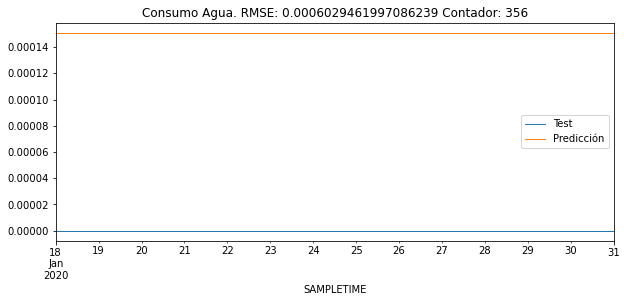

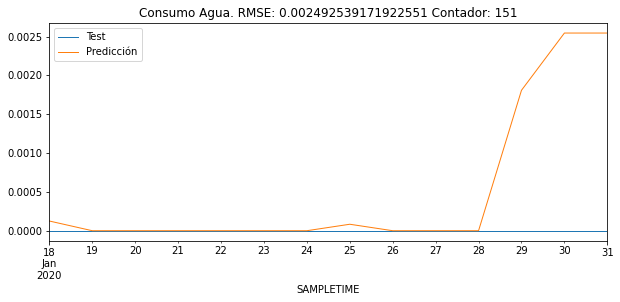

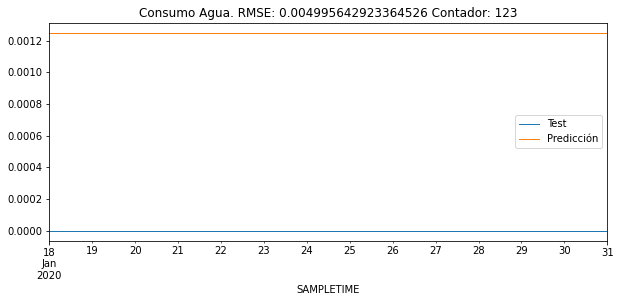

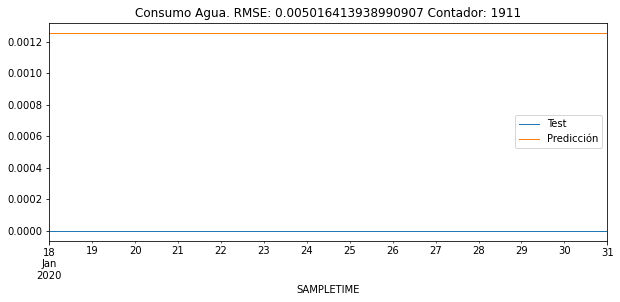

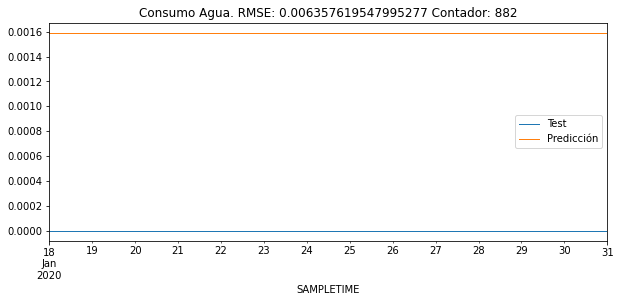

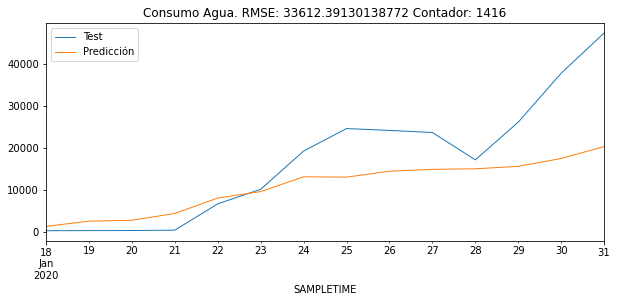

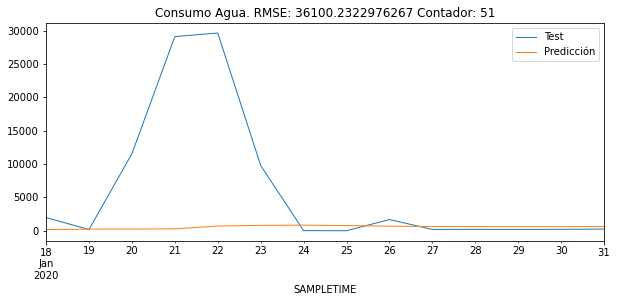

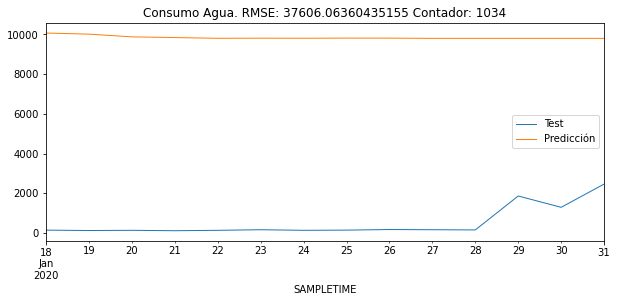

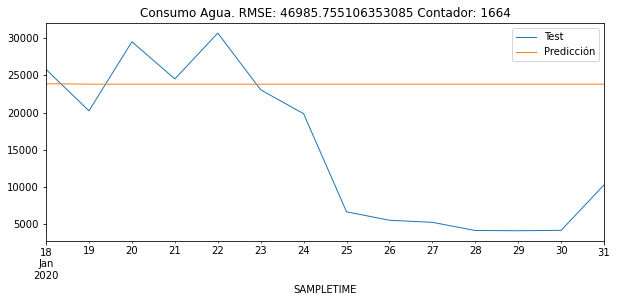

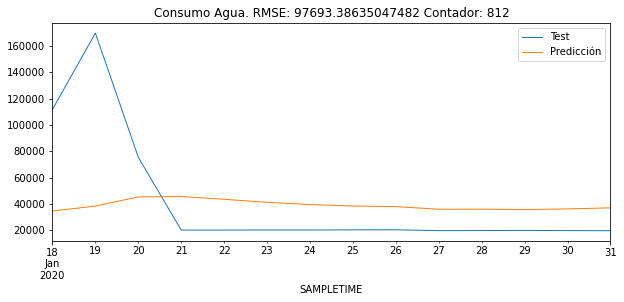

In [57]:
# ENTRENAMIENTO RESERVANDO LOS ULTIMOS 14 DIAS PARA TEST
Proyecto.PartirDatos()
Proyecto.Entrenamiento()
Proyecto.Calculo_RMSE()
# MOSTRAMOS LA PREDICCIÓN EN TEST DE LOS 5 MEJORES (EXCLUYENDO RMSE DE 0) Y LOS 5 PEORES RESULTADOS
Proyecto.Mejor_Peor_Resultado(cantidad=5)

In [ ]:
# INCLUIMOS LOS 14 DIAS DE TEST Y RE-ENTRENAMOS EL MODELO PARA GENERAR LAS PREDICCIONES
for contador in Proyecto.contadores:
    contador.Juntar_Datos()
Proyecto.Entrenamiento()
Proyecto.GenerarResultados()

# GRID CON MEDIA MOVIL Y SELECCION EN CADA CONTADOR DE LA MEJOR

In [17]:
Proyecto = CajaMar_Water('Modelar_UH2022.txt')
#Proyecto = CajaMar_Water('Modelar_UH2022_10_Contadores.txt')
#Proyecto = CajaMar_Water('/content/drive/MyDrive/Modelar_UH2022_10_Contadores.txt')
#Proyecto = CajaMar_Water('Modelar_UH2022_10_Contadores.txt',umbral_modelo=367)
#Proyecto = CajaMar_Water('Modelar_UH2022.txt', Media_Movil=30)
#Proyecto = CajaMar_Water('Modelar_UH2022_3_Contadores.txt')
#Proyecto = CajaMar_Water('Modelar_UH2022_Contador_2735.txt')
#Proyecto = CajaMar_Water('Modelar_UH2022_Contador_2561.txt')
#Proyecto = CajaMar_Water('Modelar_UH2022_Contador_2562.txt')
#Proyecto = CajaMar_Water('Modelar_UH2022_Contador_812.txt')

CARGANDO DATOS.....


  0%|          | 0/2747 [00:00<?, ?it/s]

GENERANDO CONTADORES.....


100%|██████████| 2747/2747 [19:15<00:00,  2.38it/s]

PROCESO DE CARGA FINALIZADO


100%|██████████| 2747/2747 [00:02<00:00, 1058.60it/s]


RMSE PROMEDIO:  409.76826660407727    RMSE SUMA:  1105145.0150311964


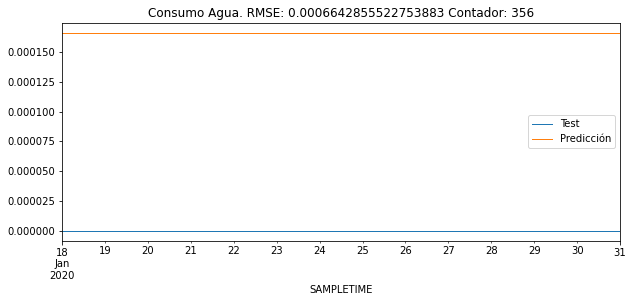

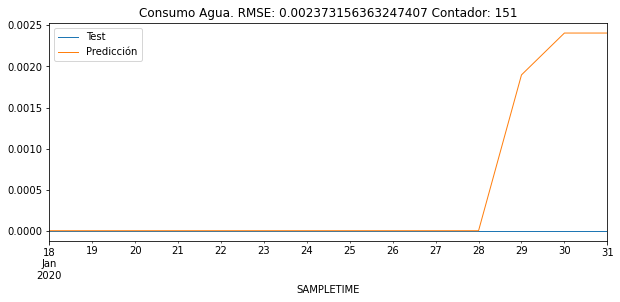

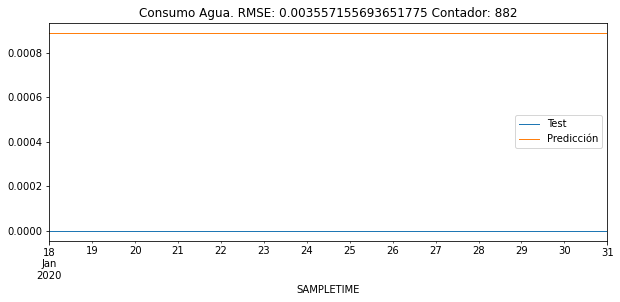

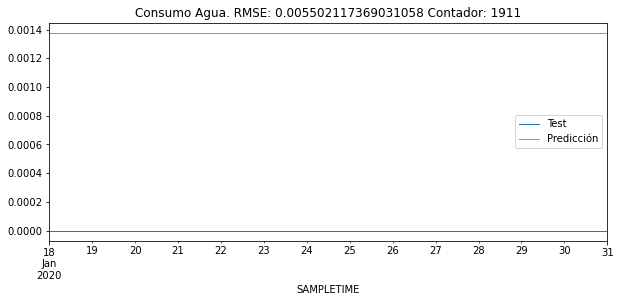

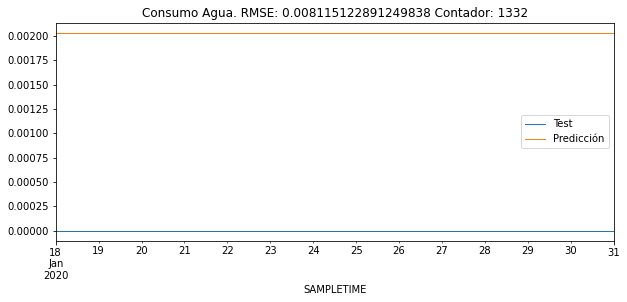

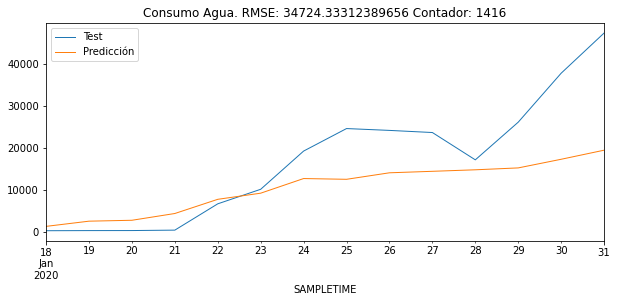

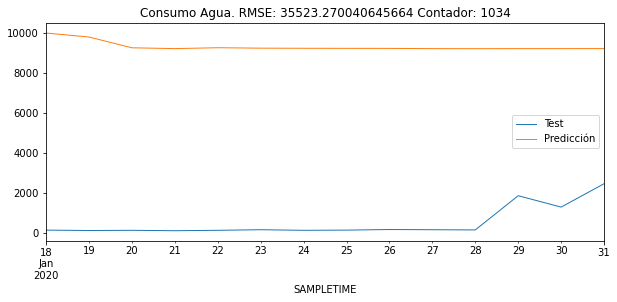

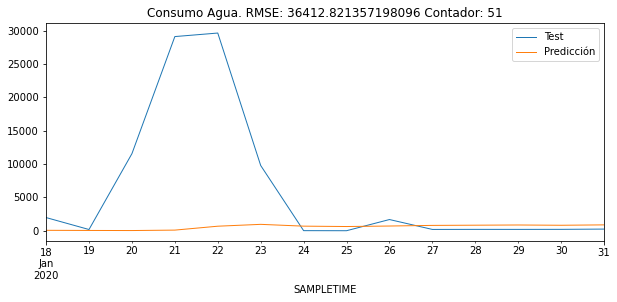

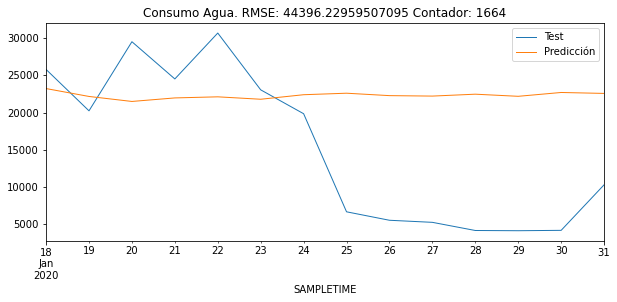

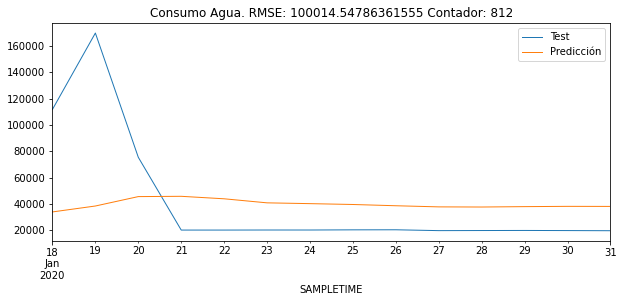

In [18]:
# ENTRENAMIENTO RESERVANDO LOS ULTIMOS 14 DIAS PARA TEST
Proyecto.PartirDatos()
Proyecto.Entrenamiento()
Proyecto.Calculo_RMSE()
# MOSTRAMOS LA PREDICCIÓN EN TEST DE LOS 5 MEJORES (EXCLUYENDO RMSE DE 0) Y LOS 5 PEORES RESULTADOS
Proyecto.Mejor_Peor_Resultado(cantidad=5)

In [19]:
# INCLUIMOS LOS 14 DIAS DE TEST Y RE-ENTRENAMOS EL MODELO PARA GENERAR LAS PREDICCIONES
for contador in Proyecto.contadores:
    contador.Juntar_Datos()
Proyecto.Entrenamiento()
Proyecto.GenerarResultados()

100%|██████████| 2747/2747 [00:00<00:00, 44105.27it/s]


TAMAÑO DE LOS DATOS:  2747 x 10


In [33]:
# GRID PARA AJUSTAR PREPROCESADO EN MEDIAS MOVILES

Proyecto.PartirDatos()
Resultados = pd.DataFrame()
RMSE = []
for x in [1,2,3,4,5,6,10,30]:
    Proyecto.Entrenamiento(media=x)
    Proyecto.Calculo_RMSE()
    for contadores in Proyecto.contadores:
        RMSE.append(contadores.RMSE_Test)
    Resultados['RMSE_MOV_'+str(x)] = RMSE
    RMSE = []

ID = []
for contador in Proyecto.contadores:
    ID.append(contador.ID)

Resultados.index = ID
Resultados


100%|██████████| 2747/2747 [00:02<00:00, 1208.56it/s]


,RMSE_MOV_1,RMSE_MOV_2,RMSE_MOV_3,RMSE_MOV_4,RMSE_MOV_5,RMSE_MOV_6,RMSE_MOV_10,RMSE_MOV_30
0,184.928347,227.741057,185.605378,177.781313,254.458780,284.340697,295.956611,235.888285
1,98.653054,92.867482,105.211486,86.262787,107.938375,123.171039,92.156809,101.875833
2,18.370650,11.404387,14.938565,14.622526,16.750119,18.921004,23.946102,18.292402
3,209.295189,189.454016,385.725907,233.260561,149.722191,282.187214,163.946228,177.489212
4,322.519759,319.695276,332.921016,336.460641,351.071528,336.776261,279.810278,117.543001
...,...,...,...,...,...,...,...,...
2746,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2747,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2748,7.299112,7.299112,7.299112,7.299112,7.299112,7.299112,7.299112,7.299112
2749,0.652450,0.652450,0.652450,0.652450,0.652450,0.652450,0.652450,0.652450


In [34]:
Resultados.to_excel("resultados_1_30.xlsx")

In [14]:
Resultados = pd.read_excel("resultados_1_30.xlsx",index_col=0)
#Resultados.drop('Mejor',axis=1,inplace=True)

In [22]:
# CALCULAMOS EL MINIMO PARA CADA CONTADOR
Mejor = []
RMSE_Mejor = []
for index, data in Resultados.iterrows():
    Mejor.append(data.argmin())
    RMSE_Mejor.append(data[data.argmin()])
Resultados['Mejor_RMSE'] = RMSE_Mejor
Resultados['Mejor'] = Mejor
Resultados

,RMSE_MOV_1,RMSE_MOV_2,RMSE_MOV_3,RMSE_MOV_4,RMSE_MOV_5,RMSE_MOV_6,RMSE_MOV_10,RMSE_MOV_30,Mejor_RMSE,Mejor
0,184.928347,227.741057,185.605378,177.781313,254.458780,284.340697,295.956611,235.888285,177.781313,3
1,98.653054,92.867482,105.211486,86.262787,107.938375,123.171039,92.156809,101.875833,86.262787,3
2,18.370650,11.404387,14.938565,14.622526,16.750119,18.921004,23.946102,18.292402,11.404387,1
3,209.295189,189.454016,385.725907,233.260561,149.722191,282.187214,163.946228,177.489212,149.722191,4
4,322.519759,319.695276,332.921016,336.460641,351.071528,336.776261,279.810278,117.543001,117.543001,7
...,...,...,...,...,...,...,...,...,...,...
2746,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2747,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2748,7.299112,7.299112,7.299112,7.299112,7.299112,7.299112,7.299112,7.299112,7.299112,0
2749,0.652450,0.652450,0.652450,0.652450,0.652450,0.652450,0.652450,0.652450,0.652450,0


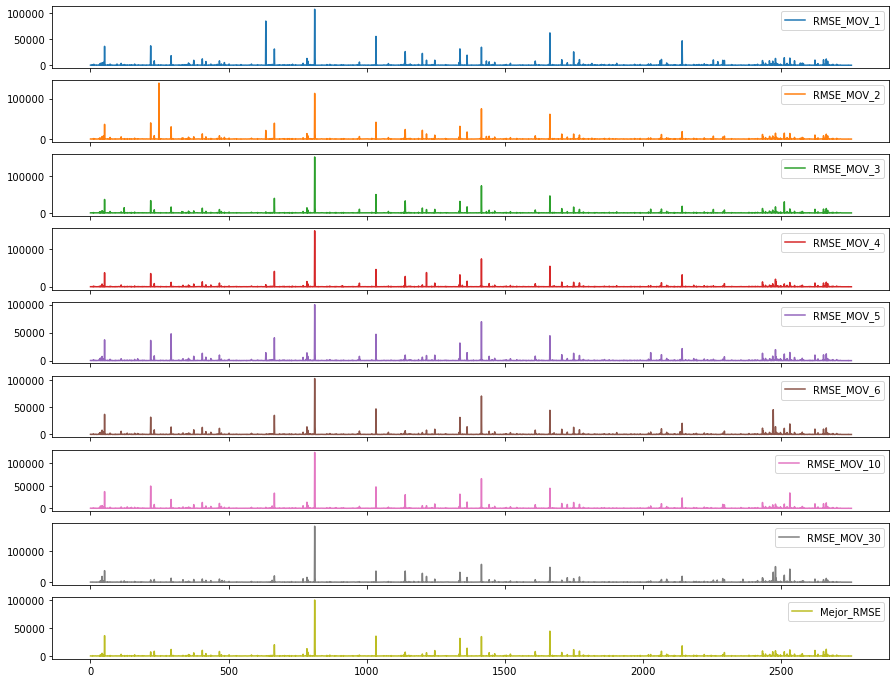

In [16]:
Resultados.drop('Mejor',axis=1,inplace=True)
Resultados.plot(subplots=True,figsize=(15,12));

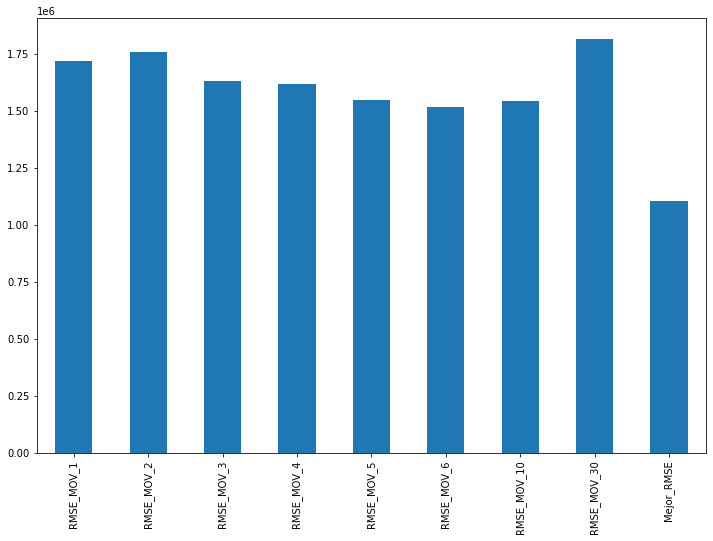

In [21]:
Resultados.sum().plot(kind='bar',figsize=(12,8));

# MODELO DIARIO Y SEMANAL

CARGANDO DATOS.....


  0%|          | 0/2747 [00:00<?, ?it/s]

GENERANDO CONTADORES.....


 14%|█▍        | 387/2747 [00:00<00:00, 3866.83it/s]

PROCESO DE CARGA FINALIZADO


100%|██████████| 2747/2747 [00:02<00:00, 1073.19it/s]


RMSE PROMEDIO:  618.478975550357    RMSE SUMA:  1668037.7970593127


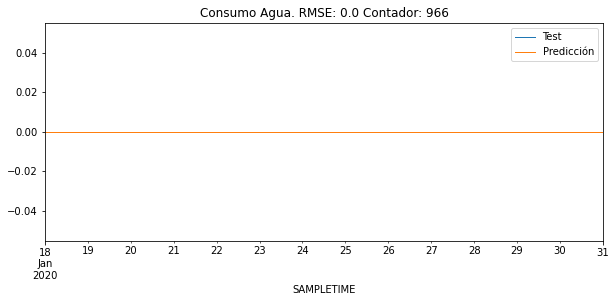

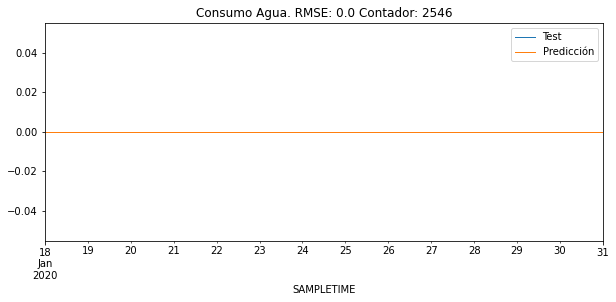

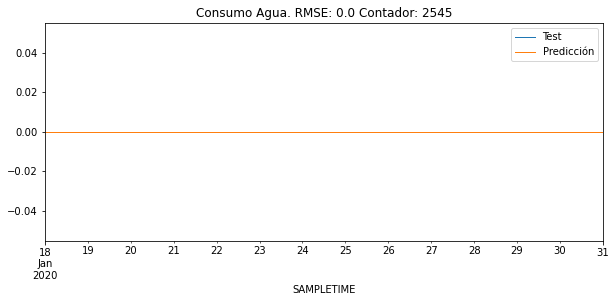

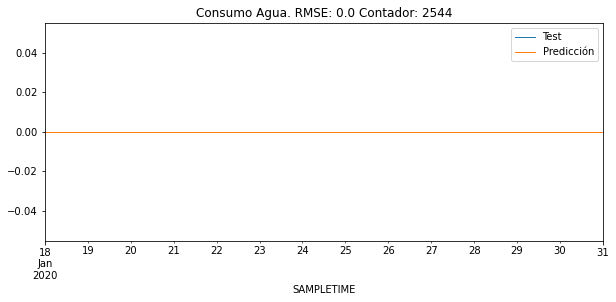

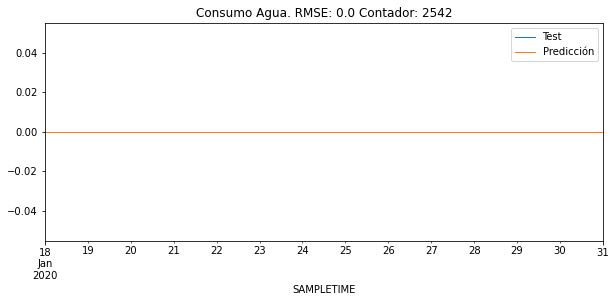

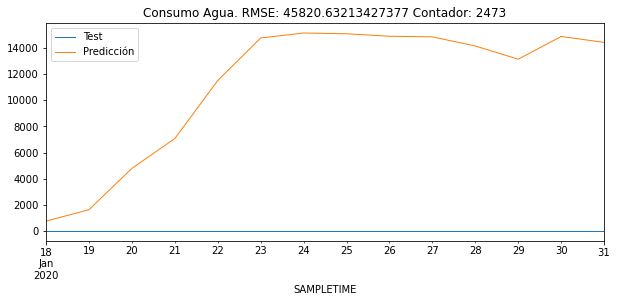

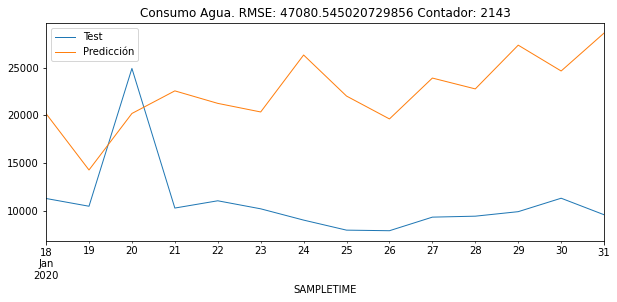

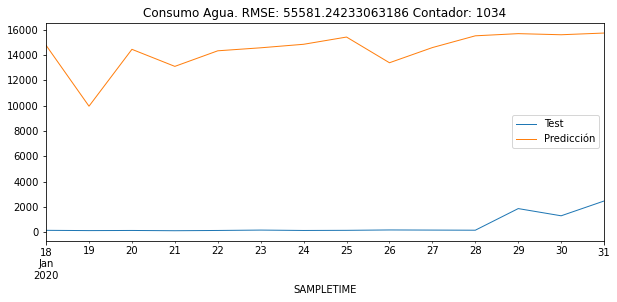

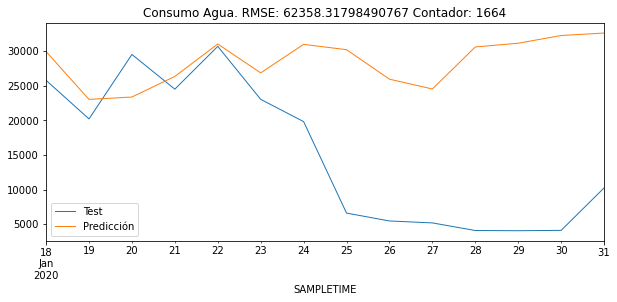

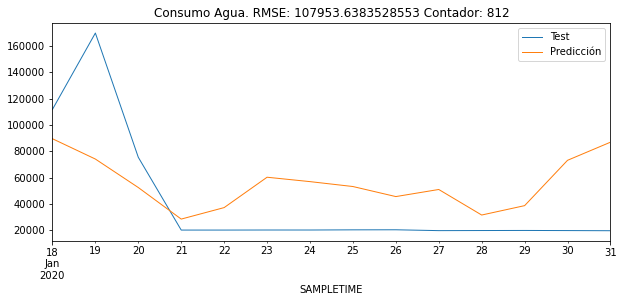

In [48]:
Proyecto = CajaMar_Water('Modelar_UH2022.txt', Modelo_Semanal=False, Media_Movil=6)
Proyecto.PartirDatos()
Proyecto.Entrenamiento()
Proyecto.Calculo_RMSE()
Proyecto.Mejor_Peor_Resultado(cantidad=5)


# COHERENCIA DE LOS DATOS

100%|██████████| 11/11 [00:00<00:00, 1426.37it/s]


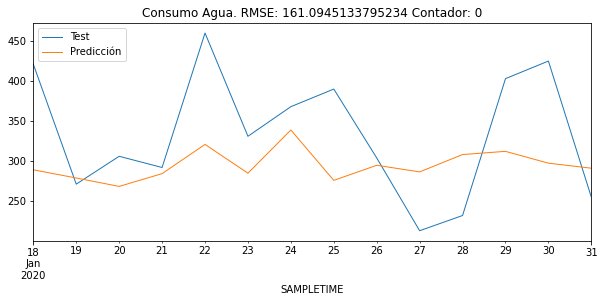

In [68]:
# Dos modelos diario y semanal
Proyecto.PartirDatos()
Proyecto.Entrenamiento()
Proyecto.Calculo_RMSE()
Proyecto.GraficasEstadisticas()


In [49]:
# Un modelo diario
Proyecto.PartirDatos()
Proyecto.Entrenamiento()
Proyecto.Calculo_RMSE()
#Proyecto.GraficasEstadisticas()


100%|██████████| 11/11 [00:00<00:00, 1167.50it/s]


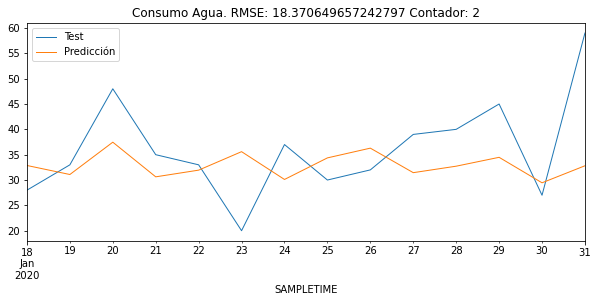

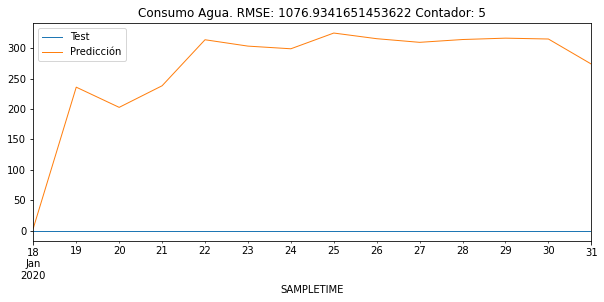

In [50]:
Proyecto.Mejor_Peor_Resultado(cantidad=1)

In [38]:
Proyecto.RMSE_Test_Promedio

738.5093258683814

In [39]:
Proyecto.RMSE_Test_Suma

2005052.8197326555

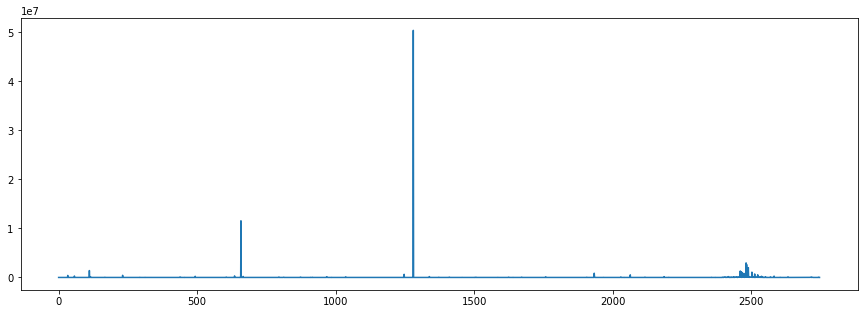

In [39]:
# DIFERENCIAS ENTRE CONSUMO Y CONSUMO CALCULADO
error = []
for contadores in Proyecto.contadores:
    error.append(contadores.DiffConsumo)

plt.figure(figsize=(15,5))
plt.plot(error)

In [40]:
for contadores in Proyecto.contadores:
    if contadores.DiffConsumo > 1000000:
        print(contadores.ID)

111
658
1280
2460
2464
2466
2481
2483
2489
2502


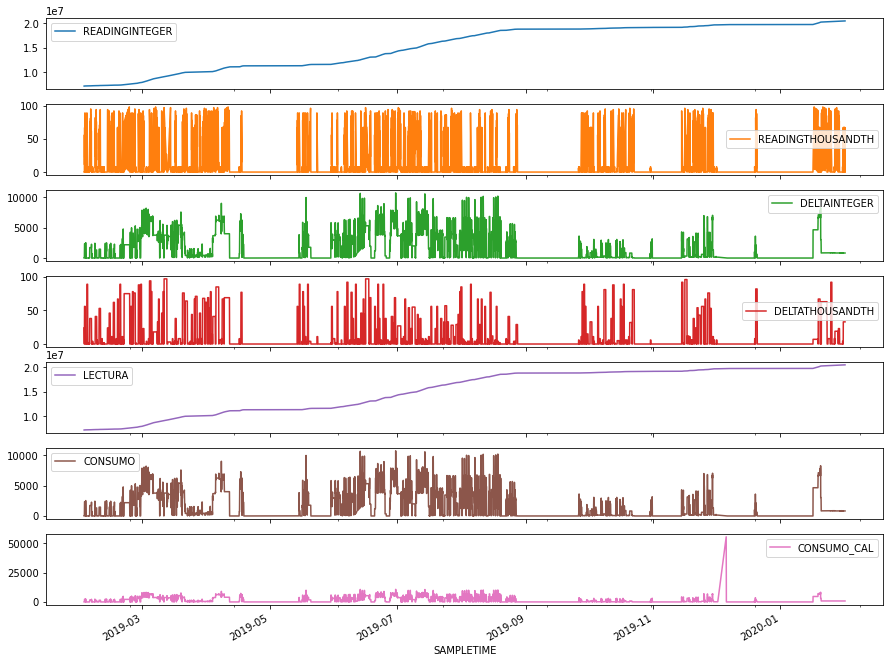

In [26]:
Proyecto.contadores[0].datos_contador.plot(subplots=True,figsize=(15,12));

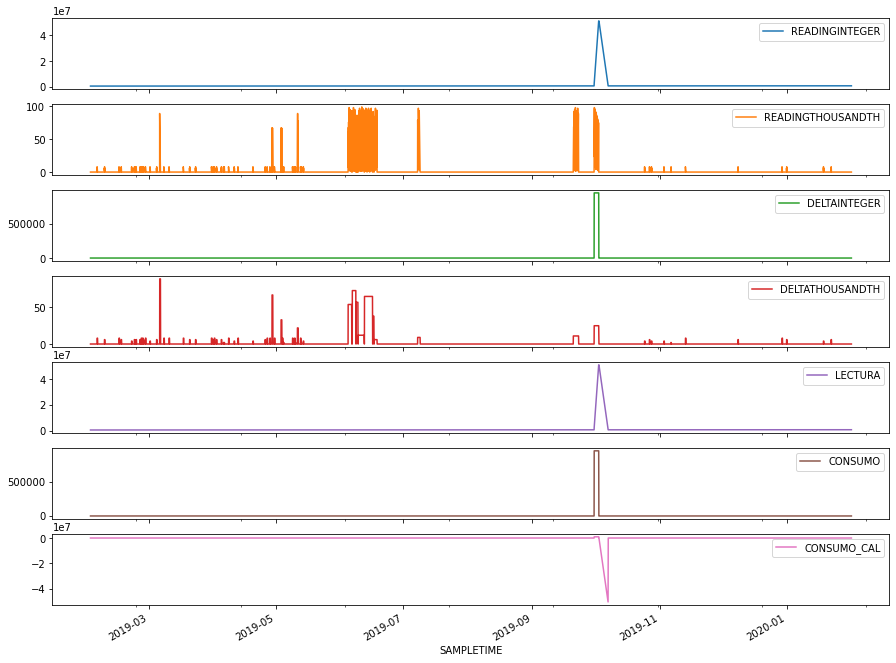

In [42]:
Proyecto.contadores[1280].datos_contador.plot(subplots=True,figsize=(15,12));

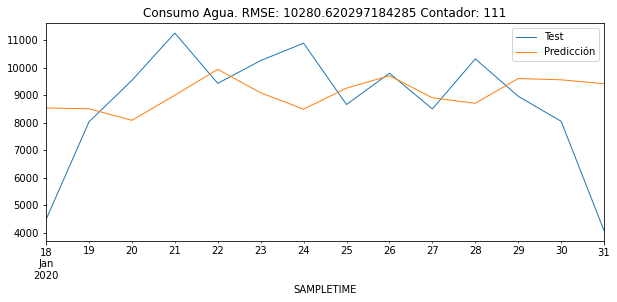

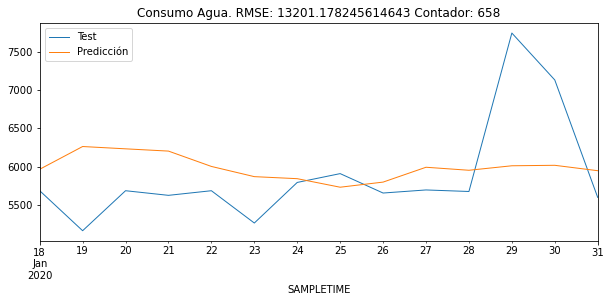

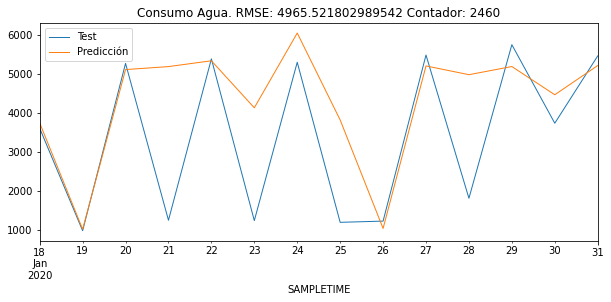

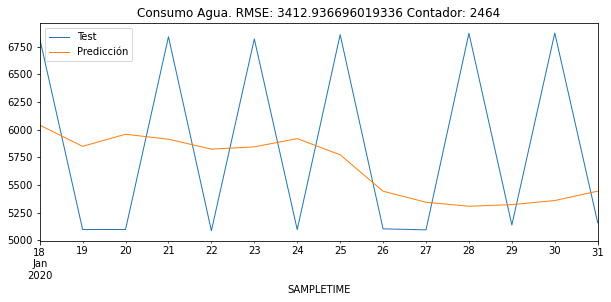

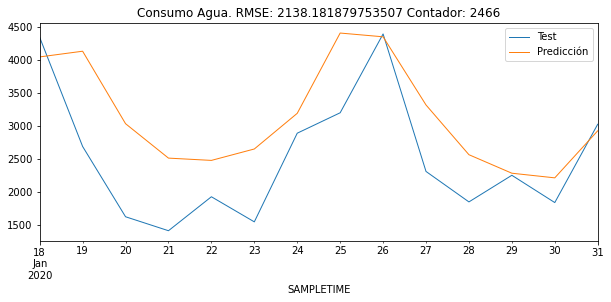

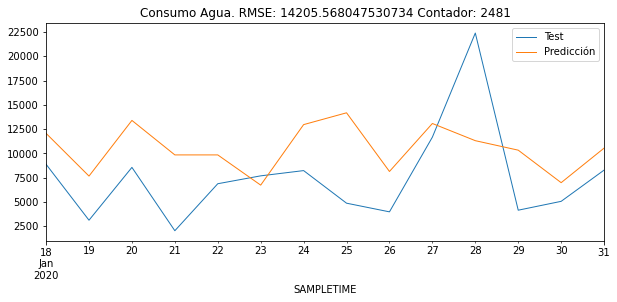

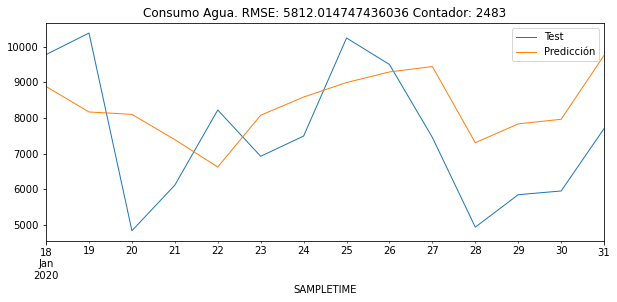

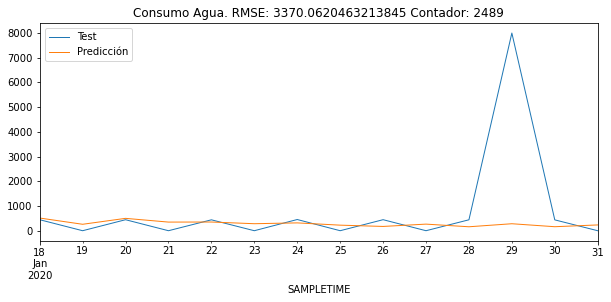

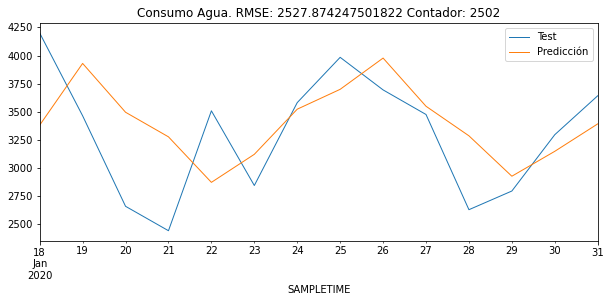

In [37]:
for ID in [111,658,2460,2464,2466,2481,2483,2489,2502]:
    Proyecto.GraficasEstadisticas(contador=ID)

# DOS MODELOS UNO PARA DIAS Y OTRO PARA SEMANAS

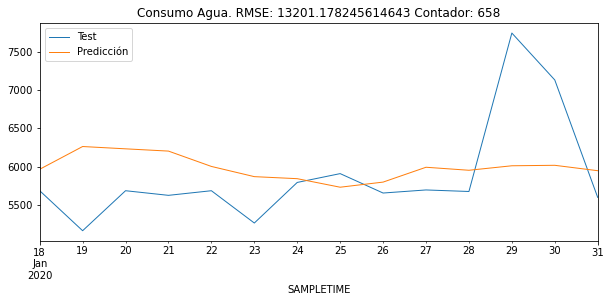

In [35]:
Proyecto.GraficasEstadisticas(contador=658)

In [13]:
Proyecto.contadores[0].datos_test

,CONSUMO,CONSUMO_NORM
SAMPLETIME,,
2020-01-18,0.0,-0.351408
2020-01-19,554.0,3.699155
2020-01-20,0.0,-0.351408
2020-01-21,0.0,-0.351408
2020-01-22,0.0,-0.351408
2020-01-23,26.0,-0.161310
2020-01-24,0.0,-0.351408
2020-01-25,0.0,-0.351408
2020-01-26,0.0,-0.351408


# GRID SEARCH RANDOM FOREST REGRESOR
 # Hiperparámetros del regresor
       #param_grid = {'n_estimators': [100,200],
       #'max_depth': [3, 5, 10]}
       #len(self.contadores[ID].datos_consumo) - 14 
       # Lags utilizados como predictores
       #lags_grid = [14, 30]

CARGANDO DATOS.....


  0%|          | 0/2747 [00:00<?, ?it/s]

GENERANDO CONTADORES.....


numexpr.utils INFO  NumExpr defaulting to 6 threads.
 15%|█▍        | 410/2747 [00:00<00:00, 4098.94it/s]

PROCESO DE CARGA FINALIZADO


  0%|          | 0/2747 [00:00<?, ?it/s]

ENTRENANDO MODELOS.....


  4%|▎         | 100/2747 [00:00<00:02, 993.06it/s]

CALCULANDO RMSE.....


100%|██████████| 2747/2747 [00:02<00:00, 1238.84it/s]


RMSE PROMEDIO:  459.90295859541044    RMSE SUMA:  1240358.279331822


100%|██████████| 2747/2747 [00:00<00:00, 263396.50it/s]

GUARDANDO MODELOS.....


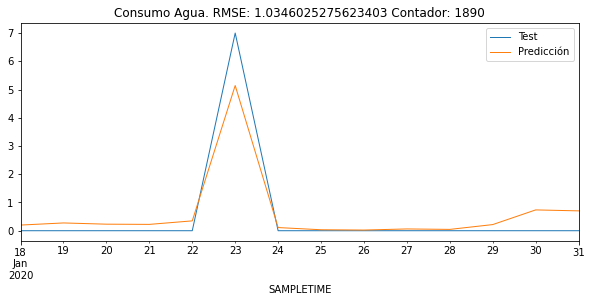

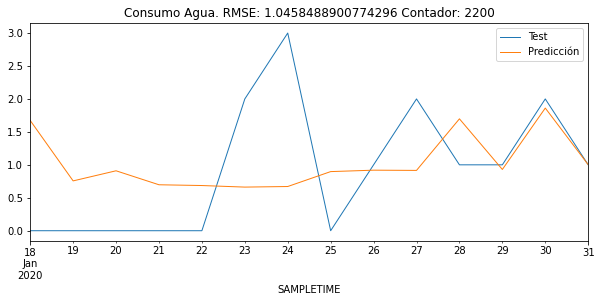

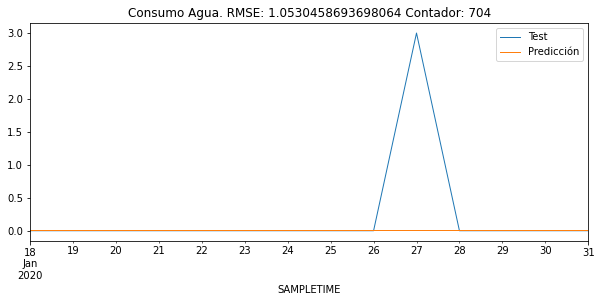

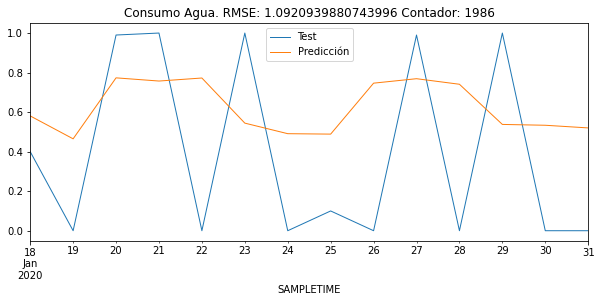

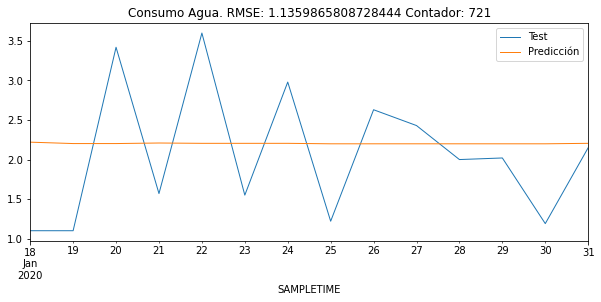

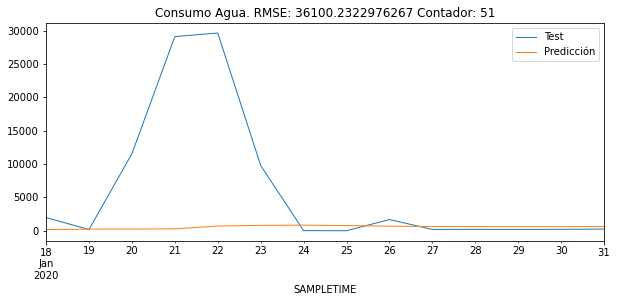

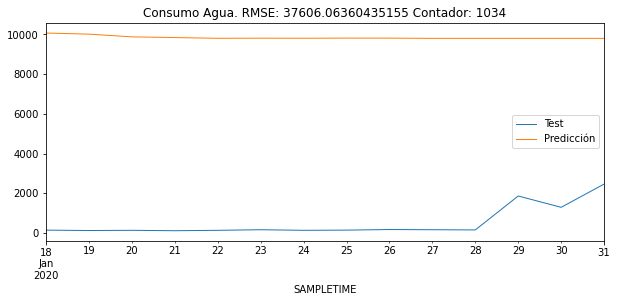

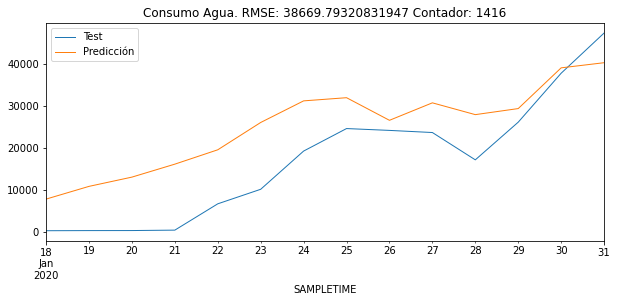

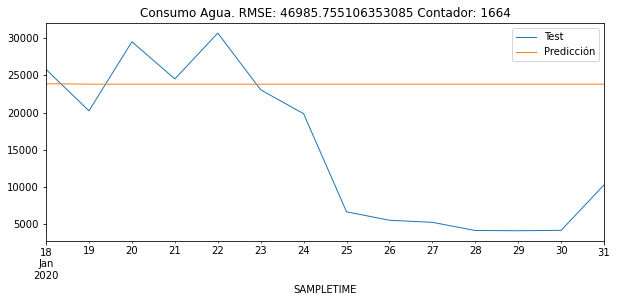

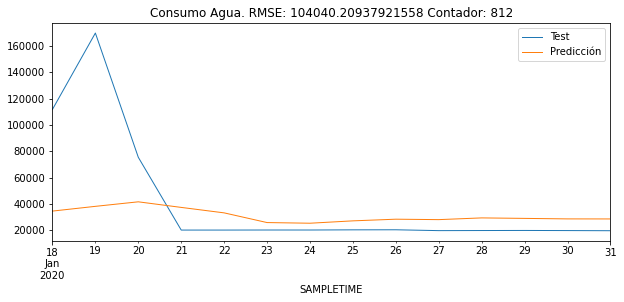

In [3]:
Proyecto = CajaMar_Water('Modelar_UH2022.txt')
Proyecto.PartirDatos()
Proyecto.Entrenamiento(Grid=True)
Proyecto.Calculo_RMSE()
Proyecto.Mejor_Peor_Resultado(cantidad=5)
# GUARDAMOS CONFIGURACIÓN DEL MEJOR MODELO EN EXCEL
Proyecto.Guardar_Modelos(Excel=True)
# RELLENADO RMSE_Train y RMSE_Test y model con el mejor modelo
# VOLVEMOS A JUNTAR LOS 14 DIAS
#for contador in Proyecto.contadores:
#    contador.Juntar_Datos()
#Proyecto.Entrenamiento()
#Proyecto.GenerarResultados(equipo='GRID')
#print(Proyecto.RMSE_Test_Promedio,Proyecto.RMSE_Test_Suma)

100%|██████████| 11/11 [00:00<00:00, 133731.43it/s]

GUARDANDO MODELOS.....


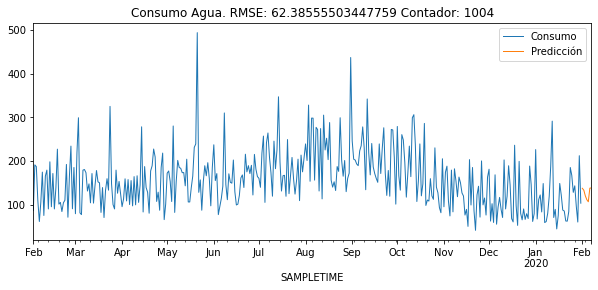

In [119]:
Proyecto.GraficasEstadisticas(1004,Test=False)

In [83]:
Proyecto.Guardar_Modelos()

  0%|          | 2/2747 [00:00<02:46, 16.44it/s]

GUARDANDO MODELOS.....


100%|██████████| 2747/2747 [02:09<00:00, 21.16it/s]


In [ ]:
#Proyecto = CajaMar_Water('Modelar_UH2022.txt')
Proyecto.PartirDatos()
Proyecto.Entrenamiento(Grid=True)
Proyecto.Calculo_RMSE()
# RELLENADO RMSE_Train y RMSE_Test y model con el mejor modelo
# VOLVEMOS A JUNTAR LOS 14 DIAS
for contador in Proyecto.contadores:
    contador.Juntar_Datos()
Proyecto.Entrenamiento()
Proyecto.GenerarResultados(equipo='GRID')

# GUARDAR MODELOS
#Proyecto.Guardar_Modelos()

In [102]:
Proyecto.Guardar_Modelos()

 36%|███▋      | 4/11 [00:00<00:00, 32.78it/s]

GUARDANDO MODELOS.....


100%|██████████| 11/11 [00:00<00:00, 34.73it/s]


In [32]:
# CARGAR MODELOS
Proyecto = CajaMar_Water('Modelar_UH2022.txt',Cargar_Modelos=True)


CARGANDO DATOS.....


  0%|          | 0/2747 [00:00<?, ?it/s]

GENERANDO CONTADORES.....


100%|██████████| 2747/2747 [20:15<00:00,  2.26it/s]


PROCESO DE CARGA FINALIZADO


In [33]:
Conf_model_Lag = []
Conf_model_max_depth = []
Conf_model_n_estimators = []
Conf_model_ID = []

for contador in tqdm(Proyecto.contadores):
    if isinstance(contador.model,ForecasterAutoreg): 
        Conf_model_Lag.append(contador.Mejor_Lag)
        Conf_model_max_depth.append(contador.Mejor_Parametro['max_depth'])
        Conf_model_n_estimators.append(contador.Mejor_Parametro['n_estimators'])
        Conf_model_ID.append(contador.ID)

Res = pd.DataFrame()
Res['Lag'] = Conf_model_Lag
Res['max_depth'] = Conf_model_max_depth
Res['n_estimators'] = Conf_model_n_estimators
Res.index = Conf_model_ID

Res.to_excel('Conf_modelos.xlsx')

100%|██████████| 2747/2747 [00:00<00:00, 252575.86it/s]


In [43]:
#self.Mejor_Lag = self.model.max_lag
#self.Mejor_Parametro = {'max_depth':self.model.regressor.max_depth,'n_estimators':self.model.regressor.n_estimators}

Res_load = pd.read_excel('Conf_modelos.xlsx',index_col=0)
for contador in tqdm(Proyecto.contadores):
    try:
        contador.model.max_lag = Res_load.loc[contador.ID]['Lag']
        contador.model.regressor.max_depth = Res_load.loc[contador.ID]['max_depth']
        contador.model.regressor.n_estimators = Res_load.loc[contador.ID]['n_estimators']
        contador.Mejor_Lag = contador.model.max_lag
        contador.Mejor_Parametro = {'max_depth':contador.model.regressor.max_depth,'n_estimators':contador.model.regressor.n_estimators}
    except:
        None

100%|██████████| 2747/2747 [00:01<00:00, 1733.51it/s]


In [40]:
Res_load.loc[0]

Lag              30
max_depth        10
n_estimators    200
Name: 0, dtype: int64

In [18]:
a

ForecasterAutoreg 
Regressor: RandomForestRegressor(max_depth=3, n_estimators=200, random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
Window size: 30 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2019-02-01 00:00:00'), Timestamp('2020-01-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-03-13 11:34:30 
Last fit date: 2022-03-13 15:31:41 
Skforecast version: 0.4.2 

In [13]:
a.max_lag

30

In [17]:
a.regressor.max_depth

3

In [19]:
a.regressor.n_estimators

200

# MODELO GANADOR PRUEBA INTERMEDIA RMSE CON SUMA

In [3]:
Proyecto = CajaMar_Water('Modelar_UH2022.txt')
Proyecto.PartirDatos()
Proyecto.Entrenamiento()
Proyecto.Calculo_RMSE()

100%|██████████| 2747/2747 [00:02<00:00, 1202.81it/s]


In [4]:
Proyecto.RMSE_Test_Suma

1723348.9862600241

In [5]:
Proyecto.RMSE_Test_Promedio

632.8861499302329

# NUMERAL=1 ENTREGA DE DATOS HACIENDO LA MEDIA

In [8]:
Proyecto = CajaMar_Water('Modelar_UH2022.txt',umbral_modelo=367)
Proyecto.PartirDatos()
Proyecto.Entrenamiento()
Proyecto.Calculo_RMSE()
print('RMSE EN TEST ULTIMOS 14 DIAS (MEDIA): ',Proyecto.RMSE_Test_Promedio)
# SIN PARTIR DATOS PARA GENERAR TXT
Proyecto = CajaMar_Water('Modelar_UH2022.txt',umbral_modelo=367)
Proyecto.Entrenamiento()
Proyecto.GenerarResultados(numeral=1)


CARGANDO DATOS.....


  0%|          | 0/2747 [00:00<?, ?it/s]

GENERANDO CONTADORES.....


 29%|██▉       | 804/2747 [00:00<00:00, 8032.86it/s]

PROCESO DE CARGA FINALIZADO


100%|██████████| 2747/2747 [00:02<00:00, 1262.36it/s]


RMSE EN TEST ULTIMOS 14 DIAS (MEDIA):  1200.8062020214459
CARGANDO DATOS.....


  0%|          | 0/2747 [00:00<?, ?it/s]

GENERANDO CONTADORES.....


100%|██████████| 2747/2747 [00:00<00:00, 1583093.31it/s]

PROCESO DE CARGA FINALIZADO
TAMAÑO DE LOS DATOS:  2747 x 10


# NUMERAL=2 ENTREGA DE DATOS CON DISTINTOS LIMITES DE UMBRAL Y EL MODELO POR DEFECTO. RANDOM FOREST REGRESOR

In [10]:
for umbral in [100,180,270]:
    Proyecto = CajaMar_Water('Modelar_UH2022.txt',umbral_modelo=umbral)
    Proyecto.PartirDatos()
    Proyecto.Entrenamiento()
    Proyecto.Calculo_RMSE()
    print('RMSE EN TEST ULTIMOS 14 DIAS (MEDIA): ',Proyecto.RMSE_Test_Promedio,' UMBRAL: ', umbral)
    # SIN PARTIR DATOS PARA GENERAR TXT
    Proyecto = CajaMar_Water('Modelar_UH2022.txt',umbral_modelo=umbral)
    Proyecto.Entrenamiento()
    Proyecto.GenerarResultados(equipo='UMBRAL',numeral=umbral)

CARGANDO DATOS.....


  0%|          | 0/2747 [00:00<?, ?it/s]

GENERANDO CONTADORES.....


 58%|█████▊    | 1595/2747 [00:00<00:00, 7983.82it/s]

PROCESO DE CARGA FINALIZADO


100%|██████████| 2747/2747 [00:02<00:00, 1281.55it/s]


RMSE EN TEST ULTIMOS 14 DIAS (MEDIA):  620.7288387410877  UMBRAL:  100
CARGANDO DATOS.....


  0%|          | 0/2747 [00:00<?, ?it/s]

GENERANDO CONTADORES.....


  0%|          | 0/2747 [00:00<?, ?it/s]

PROCESO DE CARGA FINALIZADO


100%|██████████| 2747/2747 [00:00<00:00, 129869.40it/s]


TAMAÑO DE LOS DATOS:  2747 x 10
CARGANDO DATOS.....


  0%|          | 0/2747 [00:00<?, ?it/s]

GENERANDO CONTADORES.....


  0%|          | 0/2747 [00:00<?, ?it/s]

PROCESO DE CARGA FINALIZADO


100%|██████████| 2747/2747 [00:02<00:00, 1218.56it/s]


RMSE EN TEST ULTIMOS 14 DIAS (MEDIA):  637.536231110315  UMBRAL:  180
CARGANDO DATOS.....


  0%|          | 0/2747 [00:00<?, ?it/s]

GENERANDO CONTADORES.....


  0%|          | 0/2747 [00:00<?, ?it/s]

PROCESO DE CARGA FINALIZADO


100%|██████████| 2747/2747 [00:00<00:00, 1460298.24it/s]


TAMAÑO DE LOS DATOS:  2747 x 10
CARGANDO DATOS.....


  0%|          | 0/2747 [00:00<?, ?it/s]

GENERANDO CONTADORES.....


 59%|█████▉    | 1620/2747 [00:00<00:00, 8049.92it/s]

PROCESO DE CARGA FINALIZADO


100%|██████████| 2747/2747 [00:02<00:00, 1303.33it/s]


RMSE EN TEST ULTIMOS 14 DIAS (MEDIA):  654.9834101993102  UMBRAL:  270
CARGANDO DATOS.....


  0%|          | 0/2747 [00:00<?, ?it/s]

GENERANDO CONTADORES.....


  0%|          | 0/2747 [00:00<?, ?it/s]

PROCESO DE CARGA FINALIZADO


100%|██████████| 2747/2747 [00:00<00:00, 1501010.04it/s]

TAMAÑO DE LOS DATOS:  2747 x 10


# NUMERAL 2 UMBRAL 50 RANDOM FOREST REGRESOR



In [11]:
Proyecto = CajaMar_Water('Modelar_UH2022.txt',umbral_modelo=50)
Proyecto.PartirDatos()
Proyecto.Entrenamiento()
Proyecto.Calculo_RMSE()
print('RMSE EN TEST ULTIMOS 14 DIAS (MEDIA): ',Proyecto.RMSE_Test_Promedio)
# SIN PARTIR DATOS PARA GENERAR TXT
Proyecto = CajaMar_Water('Modelar_UH2022.txt',umbral_modelo=50)
Proyecto.Entrenamiento()
Proyecto.GenerarResultados(equipo='UMBRAL',numeral=50)

CARGANDO DATOS.....


  0%|          | 0/2747 [00:00<?, ?it/s]

GENERANDO CONTADORES.....


100%|██████████| 2747/2747 [01:03<00:00, 43.48it/s]


PROCESO DE CARGA FINALIZADO


100%|██████████| 2747/2747 [00:02<00:00, 1266.47it/s]


RMSE EN TEST ULTIMOS 14 DIAS (MEDIA):  625.399573522973
CARGANDO DATOS.....


  0%|          | 0/2747 [00:00<?, ?it/s]

GENERANDO CONTADORES.....


  0%|          | 0/2747 [00:00<?, ?it/s]

PROCESO DE CARGA FINALIZADO


100%|██████████| 2747/2747 [00:00<00:00, 82858.12it/s]

TAMAÑO DE LOS DATOS:  2747 x 10


# NUMERAL 2 RANDOM FOREST UMBRAL 100 Y MODIFICACIÓN FECHA DE FIN

In [35]:
Proyecto = CajaMar_Water('Modelar_UH2022.txt',umbral_modelo=100)
Proyecto.PartirDatos()
Proyecto.Entrenamiento()
Proyecto.Calculo_RMSE()
print('RMSE EN TEST ULTIMOS 14 DIAS (MEDIA): ',Proyecto.RMSE_Test_Promedio)
# SIN PARTIR DATOS PARA GENERAR TXT
Proyecto = CajaMar_Water('Modelar_UH2022.txt',umbral_modelo=100)
Proyecto.Entrenamiento()
Proyecto.GenerarResultados(equipo='UMBRAL_FECHA_FIN',numeral=100)

CARGANDO DATOS.....


  0%|          | 0/2747 [00:00<?, ?it/s]

GENERANDO CONTADORES.....


 27%|██▋       | 731/2747 [00:00<00:00, 7302.17it/s]

PROCESO DE CARGA FINALIZADO


100%|██████████| 2747/2747 [00:02<00:00, 1068.47it/s]


RMSE EN TEST ULTIMOS 14 DIAS (MEDIA):  632.8861499302329
CARGANDO DATOS.....


  0%|          | 0/2747 [00:00<?, ?it/s]

GENERANDO CONTADORES.....


  0%|          | 0/2747 [00:00<?, ?it/s]

PROCESO DE CARGA FINALIZADO


100%|██████████| 2747/2747 [00:00<00:00, 105426.57it/s]

TAMAÑO DE LOS DATOS:  2747 x 10


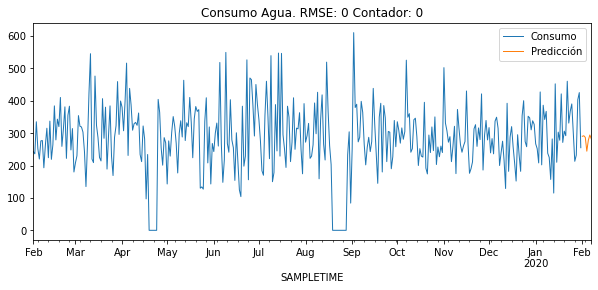

In [12]:
Proyecto.GraficasEstadisticas(Test=False)

# NUMERAL 2. UMBRAL 100 CON EXTRATREESREGRESSOR

In [17]:
Proyecto = CajaMar_Water('Modelar_UH2022.txt',umbral_modelo=100)
Proyecto.PartirDatos()
Proyecto.Entrenamiento()
Proyecto.Calculo_RMSE()
print('RMSE EN TEST ULTIMOS 14 DIAS (MEDIA): ',Proyecto.RMSE_Test_Promedio)
# SIN PARTIR DATOS PARA GENERAR TXT
Proyecto = CajaMar_Water('Modelar_UH2022.txt',umbral_modelo=100)
Proyecto.Entrenamiento()
Proyecto.GenerarResultados(equipo='UMBRAL_EXTRA_TREES_',numeral=100)

CARGANDO DATOS.....


  0%|          | 0/2747 [00:00<?, ?it/s]

GENERANDO CONTADORES.....


 29%|██▉       | 791/2747 [00:00<00:00, 7907.41it/s]

PROCESO DE CARGA FINALIZADO


100%|██████████| 2747/2747 [00:02<00:00, 983.43it/s] 


RMSE EN TEST ULTIMOS 14 DIAS (MEDIA):  661.5675509801729
CARGANDO DATOS.....


  0%|          | 0/2747 [00:00<?, ?it/s]

GENERANDO CONTADORES.....


  0%|          | 0/2747 [00:00<?, ?it/s]

PROCESO DE CARGA FINALIZADO


100%|██████████| 2747/2747 [00:00<00:00, 75416.98it/s]

TAMAÑO DE LOS DATOS:  2747 x 10


# EVALUANDO MEJOR MODELO

In [31]:
Proyecto = CajaMar_Water('Modelar_UH2022.txt',umbral_modelo=100)
Proyecto.PartirDatos()
Proyecto.Entrenamiento()
Proyecto.Calculo_RMSE()

# HAY 117 CONTADORES QUE LA FECHA DE FIN NO ES 31 DE ENERO
for contadores in Proyecto.contadores:
    if contadores.fecha_fin_contador != Proyecto.Fecha_Fin:
        print(contadores.ID, contadores.fecha_fin_contador, contadores.dias, contadores.RMSE_Test)

CARGANDO DATOS.....


  0%|          | 0/2747 [00:00<?, ?it/s]

GENERANDO CONTADORES.....


 29%|██▊       | 783/2747 [00:00<00:00, 7825.40it/s]

PROCESO DE CARGA FINALIZADO


100%|██████████| 2747/2747 [00:02<00:00, 1091.46it/s]

116 2020-01-26 00:00:00 356 351.01669978784605
167 2020-01-24 00:00:00 356 480.0087433110364
209 2019-09-12 00:00:00 221 0.0
231 2020-01-21 00:00:00 338 2.707559614151996
260 2020-01-28 00:00:00 362 344.680574049081
293 2020-01-26 00:00:00 360 593.4891695568385
371 2020-01-25 00:00:00 359 61.26063990179608
386 2020-01-29 00:00:00 363 198.08181760746268
438 2019-12-24 00:00:00 293 496.849235403081
441 2020-01-22 00:00:00 356 91.28320773387397
525 2020-01-23 00:00:00 357 226.73811399078548
654 2020-01-29 00:00:00 363 662.4690722267934
795 2019-11-24 00:00:00 266 1735.8137417744654
813 2020-01-30 00:00:00 322 26850.21324157027
860 2020-01-29 00:00:00 363 242.26684664849682
969 2020-01-30 00:00:00 364 942.4844469139922
1022 2020-01-23 00:00:00 357 81.71088839752016
1041 None 0 0
1133 2020-01-26 00:00:00 356 115.61139141635249
1174 2020-01-27 00:00:00 360 403.6306478559143
1247 2020-01-26 00:00:00 360 17943.852704328598
1338 2020-01-19 00:00:00 353 11021.806712897429
1367 2019-09-25 00:00:0

In [25]:
for contadores in Proyecto.contadores:
    if contadores.ID == 116:
        print(contadores.datos_consumo)

            CONSUMO
SAMPLETIME         
2019-02-05     0.00
2019-02-06     0.00
2019-02-07     0.00
2019-02-08     0.00
2019-02-09     0.00
...             ...
2020-01-22   282.17
2020-01-23   229.02
2020-01-24   246.24
2020-01-25   246.24
2020-01-26    56.04

[356 rows x 1 columns]


# CORRELACION Y GRAFICAS VARIAS

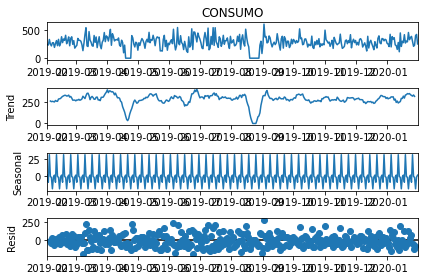

In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(Proyecto.contadores[0].datos_consumo['CONSUMO'],model='additive')
decomposition.plot()
plt.show()

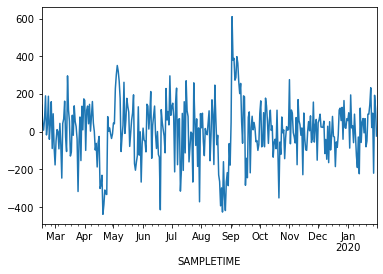

In [57]:
# ESTACIONALIDAD SEMANAL:

datos_semanal = Proyecto.contadores[0].datos_consumo['CONSUMO'].diff(14).dropna()
datos_semanal.plot()
plt.show()

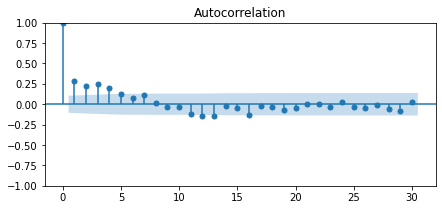

In [76]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Gráfico autocorrelación
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(Proyecto.contadores[0].datos_consumo['Consumo'], ax=ax, lags=30)
plt.show()

/Users/felipe/opt/anaconda3/envs/TFM/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


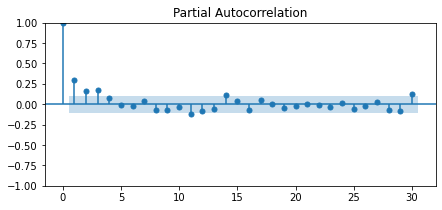

In [77]:
# Gráfico autocorrelación parcial
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_pacf(Proyecto.contadores[0].datos_consumo['Consumo'], ax=ax, lags=30)
plt.show()

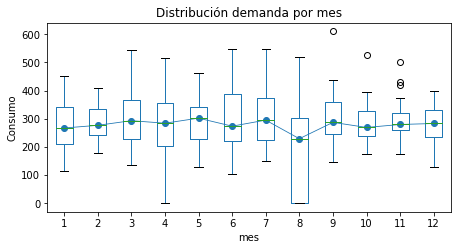

In [91]:
# Gráfico boxplot para estacionalidad anual
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3.5))
Proyecto.contadores[0].datos_consumo['mes'] = pd.to_datetime(Proyecto.contadores[0].datos_consumo['Fecha']).dt.month
Proyecto.contadores[0].datos_consumo.boxplot(column='Consumo', by='mes', ax=ax,)
Proyecto.contadores[0].datos_consumo.groupby('mes')['Consumo'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Consumo')
ax.set_title('Distribución demanda por mes')
fig.suptitle('');

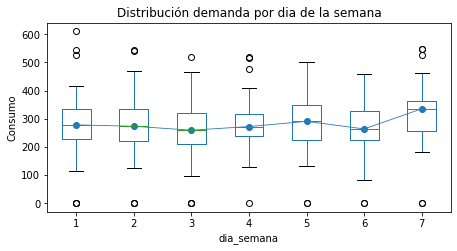

In [94]:
# Gráfico boxplot para estacionalidad semanal
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3.5))
Proyecto.contadores[0].datos_consumo['dia_semana'] = pd.to_datetime(Proyecto.contadores[0].datos_consumo['Fecha']).dt.day_of_week + 1
Proyecto.contadores[0].datos_consumo.boxplot(column='Consumo', by='dia_semana', ax=ax)
Proyecto.contadores[0].datos_consumo.groupby('dia_semana')['Consumo'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Consumo')
ax.set_title('Distribución demanda por dia de la semana')
fig.suptitle('');

2747


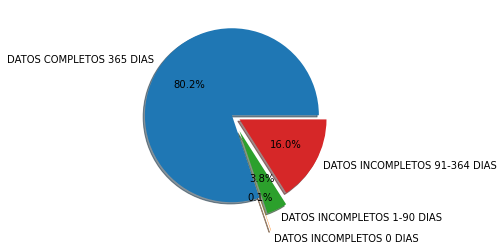

In [113]:
# ESTADISTICAS DATOS

completo = 0
incompleto_0 = 0
incompleto_m_100 = 0
incompleto_M_100 = 0

for contador in Proyecto.contadores:
    if  contador.dias == 365:
        completo += 1
    if contador.dias == 0:
        incompleto_0 += 1
    if contador.dias <= 90 and contador.dias > 0:
        incompleto_m_100 += 1
    if contador.dias > 90 and contador.dias < 365:
        incompleto_M_100 += 1

print(completo + incompleto_0 + incompleto_M_100 + incompleto_m_100)       


y = np.array([completo,incompleto_0,incompleto_m_100,incompleto_M_100 ])

def absolute_value(val):
    a  = np.round(val/100.*y.sum(), 0)
    return a
mylabels = ["DATOS COMPLETOS 365 DIAS", "DATOS INCOMPLETOS 0 DIAS", "DATOS INCOMPLETOS 1-90 DIAS","DATOS INCOMPLETOS 91-364 DIAS"]
myexplode = [0, 0.4,0.2,0.1]

plt.pie(y, labels = mylabels, explode = myexplode, autopct='%1.1f%%', shadow = True)
#plt.legend()
plt.show()